This notebook illustrates the use of convolutional networks for a multiclass classification over the MNIST dataset in particular, it studies the effect of the Dropout. This notebook is based on the PyTorch MNIST example: https://github.com/pytorch/examples/tree/master/mnist
You can find the slides with the final results in the following link: https://docs.google.com/presentation/d/1VXqU6CAa5OJh4NNo9mFjXPJkeShgIgS78drYmn3Z06s/edit?usp=sharing

The MNIST dataset contains handwritten digits like these:

 ![MNIST samples](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

Each digit is 28x28 pixels and is labeled with the digit it contains, e.g. this is labeled with a "0":

<img src="http://neuralnetworksanddeeplearning.com/images/mnist_complete_zero.png" width="200">


In [0]:
!pip install pillow==5.4.1
!pip install matplotlib
!pip install scikit-learn
!pip install torch
!pip install torchvision

    100% |████████████████████████████████| 2.0MB 15.9MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
  [PIL]
You must restart the runtime in order to use newly installed versions.


In [0]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

Let's define our first model. We will insert a dropout layer after both max_pool2d and after the first fully-connected layer.  We will compare the results for diferent dropouts, with a probability of 0,0.1,0.2,0.5 and 0.8

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
        self.dropout = nn.Dropout()
        self.dropout2d = nn.Dropout2d()

    def forward(self, x, p):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.dropout2d(x,p)
        x = F.relu(self.conv2(x))        
        x = F.max_pool2d(x, 2, 2)
        x = F.dropout2d(x,p)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = F.dropout(x,p)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

Now let's create a function that trains over an epoch. Every N steps we will `print` the progress. As input to the training, we are going to assume we receive an iterator to the training batches.

Note that, as we are facing a multiclass classification problem, we use the **negative log likelihood** (NLL) as loss function.

In [0]:
def train(log_interval, model, device, train_loader, optimizer, epoch, p):
    losses = []
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data, p)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return losses

And now let's create a similar function but to evaluate the performance of the model over a validation data set:

In [0]:
def validate(model, device, loader):
    
    model.eval()  # let's put the model in evaluation mode

    validation_loss = 0
    correct = 0
    
    with torch.no_grad():  # we don't need gradient computation at all
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data,0)
            validation_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    validation_loss /= len(loader.dataset)

    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(loader.dataset),
        100. * correct / len(loader.dataset)))
    
    accuracy = 100. * correct / len(loader.dataset)
    
    return validation_loss, accuracy


Now, we will use the dataset from `torchvision` to load MNIST and the PyTorch loaders to get iterators to the batches, for both training and validation data.

Note that we apply a linear transformation to normalize the data.

In [0]:
train_batch_size = 128

mnist_mean = 0.1307
mnist_stddev = 0.3081
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data',
                   train=True,
                   download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((mnist_mean,), (mnist_stddev,))
                   ])),
    batch_size=train_batch_size,
    shuffle=True)

valid_batch_size = 1000
valid_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data',
                   train=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((mnist_mean,), (mnist_stddev,))
                   ])),
    batch_size=valid_batch_size,
    shuffle=True)

And finally, let's create the network, move it to the GPU and iterate through some epochs of training:

The dropout probability is: 0
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.308557
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.588553
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.363539
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.231897
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.300837
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.168768

Validation set: Average loss: 0.1502, Accuracy: 9548/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.167293
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.163928
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.127488
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.080744
Train Epoch: 2 [40960/60000 (68%)]	Loss: 0.126802
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.151597

Validation set: Average loss: 0.0785, Accuracy: 9763/10000 (98%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.096062
Train Epoch: 3 [10240/60000 (17%)]	Loss: 0.100826
Train Epoch: 3 [20480/60000 (34%)]	Loss: 0.130797
Train Epoch: 3 [30720/60000 (51%)]	Loss: 0.095780
Train Epoch: 3 [40960/60000 (68%)]	Loss: 0.070437
T

<Figure size 576x396 with 0 Axes>

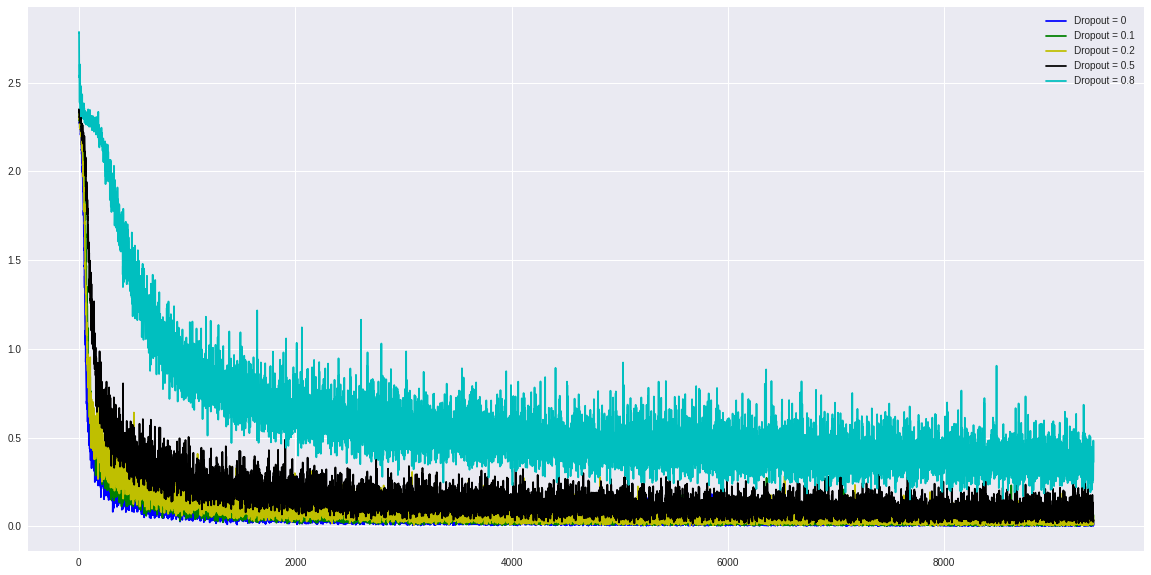

<Figure size 576x396 with 0 Axes>

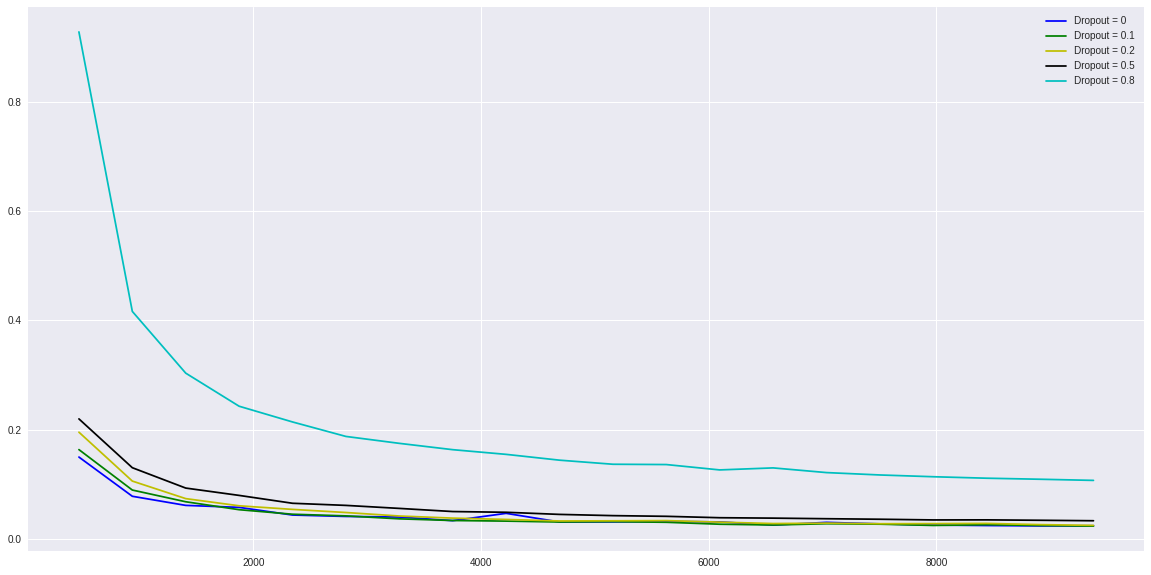

<Figure size 576x396 with 0 Axes>

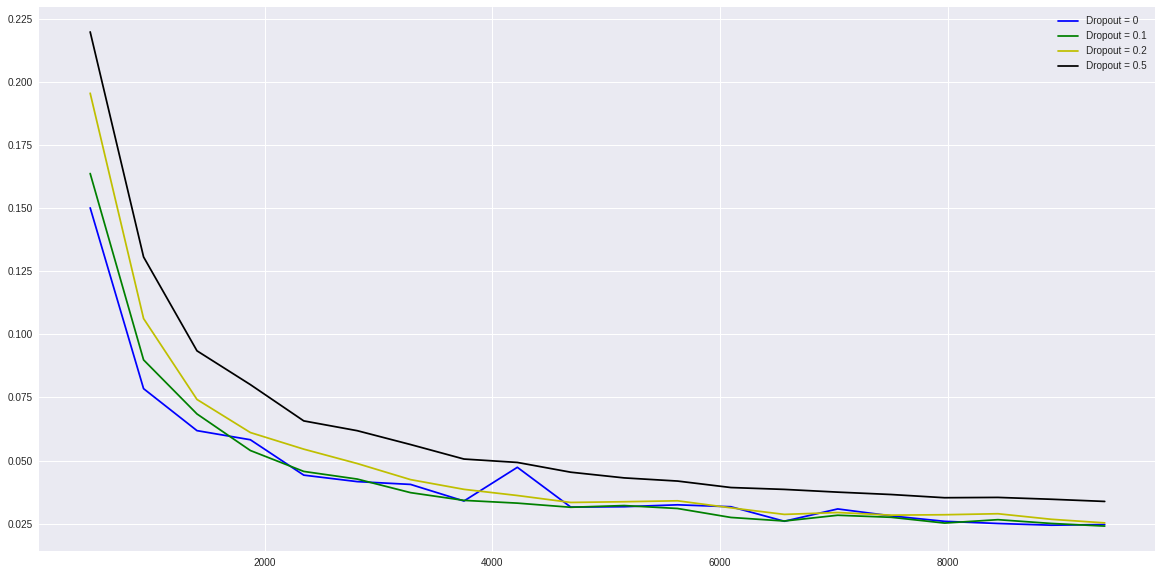

<Figure size 576x396 with 0 Axes>

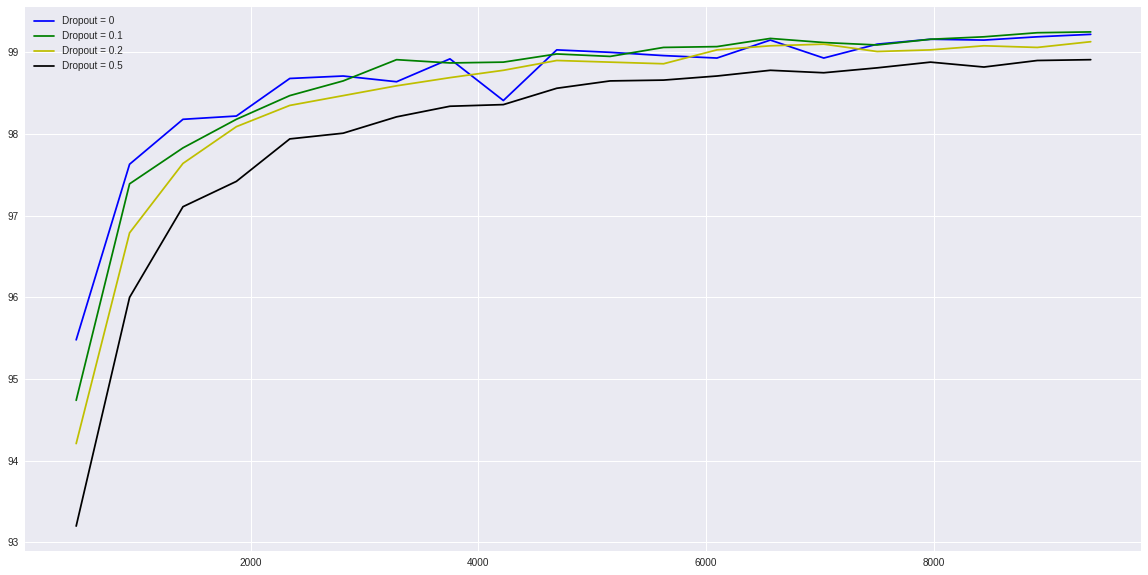

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vector_p=[0,0.1,0.2,0.5,0.8]
colors=['b-', 'g-', 'y-', 'k-', 'c-']
train_losses_m = []
valid_losses_m = []
valid_x_m = []
accuracy_m = []
plt.gcf().clear()
plt.figure(figsize=(20,10))
for p in vector_p:
  model = Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
  print("The dropout probability is: "+str(p))
  train_losses = []
  valid_losses = []
  valid_x=[]
  accuracies = []
  num_epochs = 20
  for epoch in range(1, num_epochs + 1):
      epoch_losses = train(80, model, device, train_loader, optimizer, epoch, p)
      train_losses.extend(epoch_losses)
      valid_loss, accuracy = validate(model, device, valid_loader)
      valid_losses.append([valid_loss])
      accuracies.append([accuracy])
      valid_x.append(len(train_losses) - 1)
  valid_x_m.append(valid_x)
  train_losses_m.append(train_losses)
  valid_losses_m.append(valid_losses)
  accuracy_m.append(accuracies)

  plt.plot(train_losses, colors[vector_p.index(p)], label = 'Dropout = ' + str(p) )
  plt.legend(loc='upper right')
 
plt.show()
plt.gcf().clear()
plt.figure(figsize=(20,10))
for i in range(len(vector_p)): 
  plt.plot(valid_x_m[i], valid_losses_m[i], colors[i], label = 'Dropout = ' + str(vector_p[i]))
  plt.legend(loc='upper right')
plt.show()

plt.gcf().clear()
plt.figure(figsize=(20,10))
for i in range(len(vector_p)-1): 
  plt.plot(valid_x_m[i], valid_losses_m[i], colors[i], label = 'Dropout = ' + str(vector_p[i]))
  plt.legend(loc='upper right')
plt.show()

plt.gcf().clear()
plt.figure(figsize=(20,10))
for i in range(len(vector_p)-1): 
  plt.plot(valid_x_m[i], accuracy_m[i], colors[i], label = 'Dropout = ' + str(vector_p[i]))
  plt.legend(loc='upper left')
plt.show()




<Figure size 576x396 with 0 Axes>

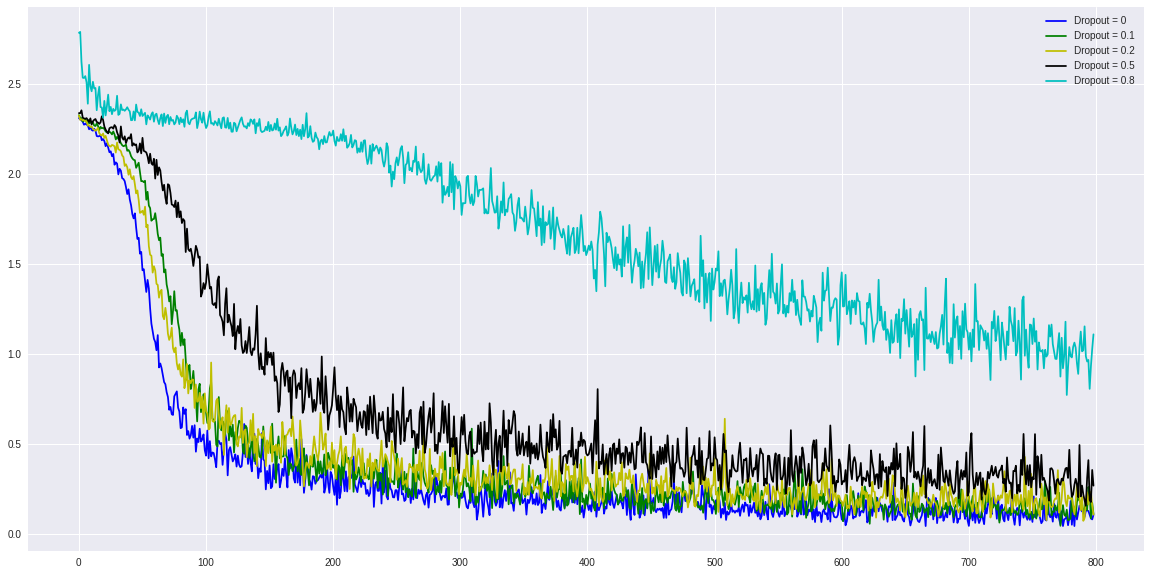

In [0]:
plt.gcf().clear()
plt.figure(figsize=(20,10))
for i in range(len(vector_p)): 
  plt.plot(train_losses_m[i][0:799], colors[i], label = 'Dropout = ' + str(vector_p[i]))
  plt.legend(loc='upper right')
plt.show()

On our second model we will add dropout only in the first fully-connected layer, since we think we could get better performance using dropout in another way.  

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
        self.dropout = nn.Dropout()
        self.dropout2d = nn.Dropout2d()

    def forward(self, x, p):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = F.dropout(x,p)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

The dropout probability is: 0
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.316554
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.518528
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.335012
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.303703
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.170754
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.167626

Validation set: Average loss: 0.1598, Accuracy: 9539/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.191441
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.085477
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.157185
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.092101
Train Epoch: 2 [40960/60000 (68%)]	Loss: 0.189225
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.132958

Validation set: Average loss: 0.0929, Accuracy: 9716/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.054947
Train Epoch: 3 [10240/60000 (17%)]	Loss: 0.082466
Train Epoch: 3 [20480/60000 (34%)]	Loss: 0.097485
Train Epoch: 3 [30720/60000 (51%)]	Loss: 0.060684
Train Epoch: 3 [40960/60000 (68%)]	Loss: 0.036656
T

<Figure size 576x396 with 0 Axes>

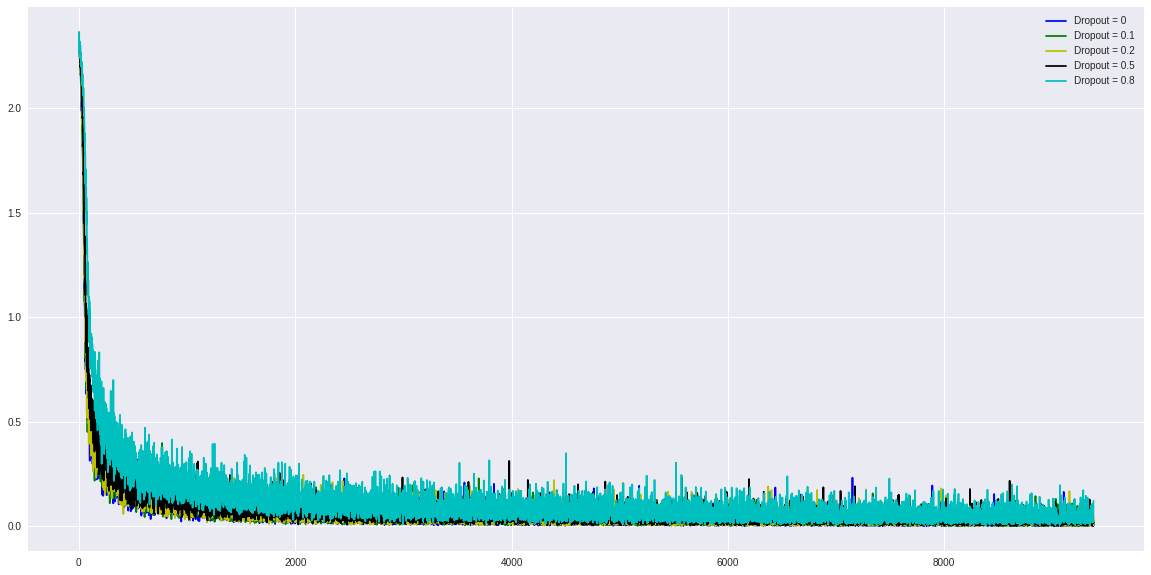

<Figure size 576x396 with 0 Axes>

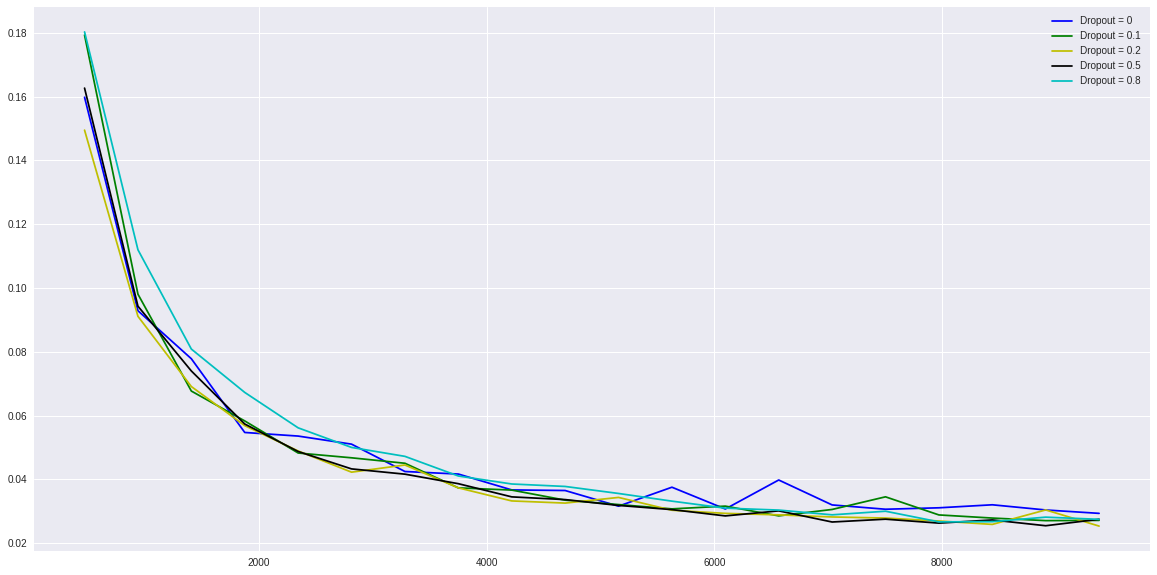

<Figure size 576x396 with 0 Axes>

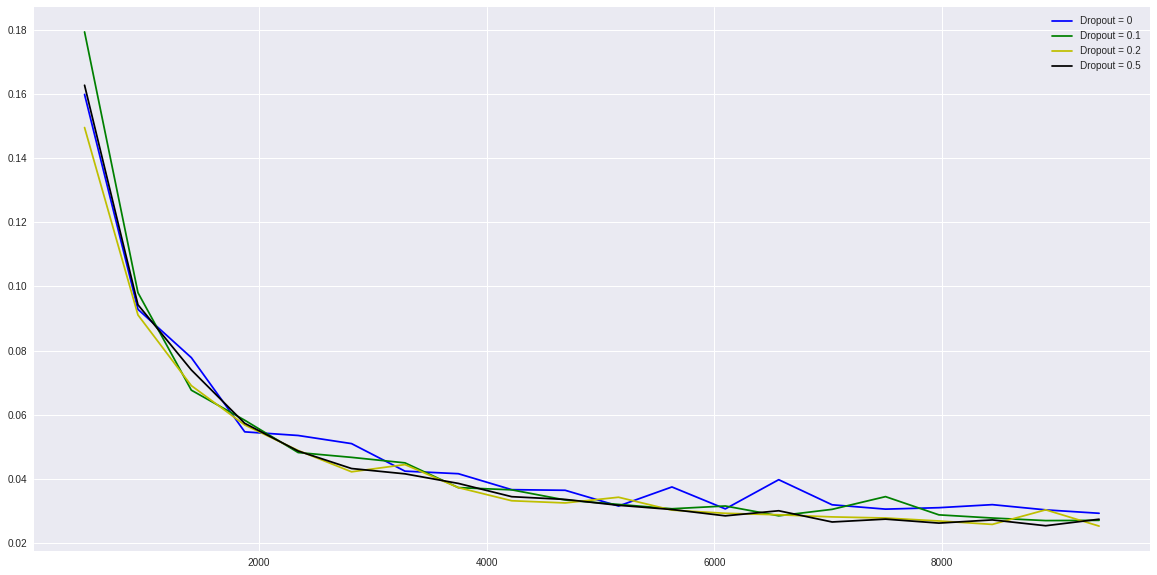

<Figure size 576x396 with 0 Axes>

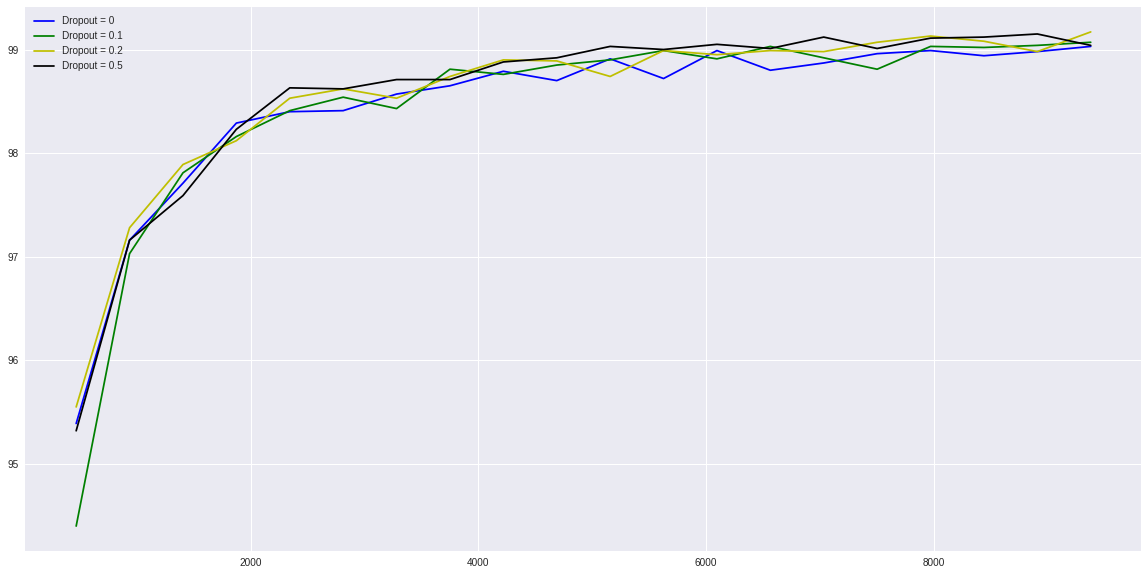

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vector_p=[0,0.1,0.2,0.5,0.8]
colors=['b-', 'g-', 'y-', 'k-', 'c-']
train_losses_m = []
valid_losses_m = []
valid_x_m = []
accuracy_m = []
plt.gcf().clear()
plt.figure(figsize=(20,10))
for p in vector_p:
  model = Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
  print("The dropout probability is: "+str(p))
  train_losses = []
  valid_losses = []
  valid_x=[]
  accuracies = []
  num_epochs = 20
  for epoch in range(1, num_epochs + 1):
      epoch_losses = train(80, model, device, train_loader, optimizer, epoch, p)
      train_losses.extend(epoch_losses)
      valid_loss, accuracy = validate(model, device, valid_loader)
      valid_losses.append([valid_loss])
      accuracies.append([accuracy])
      valid_x.append(len(train_losses) - 1)
  valid_x_m.append(valid_x)
  train_losses_m.append(train_losses)
  valid_losses_m.append(valid_losses)
  accuracy_m.append(accuracies)

  plt.plot(train_losses, colors[vector_p.index(p)], label = 'Dropout = ' + str(p) )
  plt.legend(loc='upper right')
 
plt.show()
plt.gcf().clear()
plt.figure(figsize=(20,10))
for i in range(len(vector_p)): 
  plt.plot(valid_x_m[i], valid_losses_m[i], colors[i], label = 'Dropout = ' + str(vector_p[i]))
  plt.legend(loc='upper right')
plt.show()

plt.gcf().clear()
plt.figure(figsize=(20,10))
for i in range(len(vector_p)-1): 
  plt.plot(valid_x_m[i], valid_losses_m[i], colors[i], label = 'Dropout = ' + str(vector_p[i]))
  plt.legend(loc='upper right')
plt.show()

plt.gcf().clear()
plt.figure(figsize=(20,10))
for i in range(len(vector_p)-1): 
  plt.plot(valid_x_m[i], accuracy_m[i], colors[i], label = 'Dropout = ' + str(vector_p[i]))
  plt.legend(loc='upper left')
plt.show()




<Figure size 576x396 with 0 Axes>

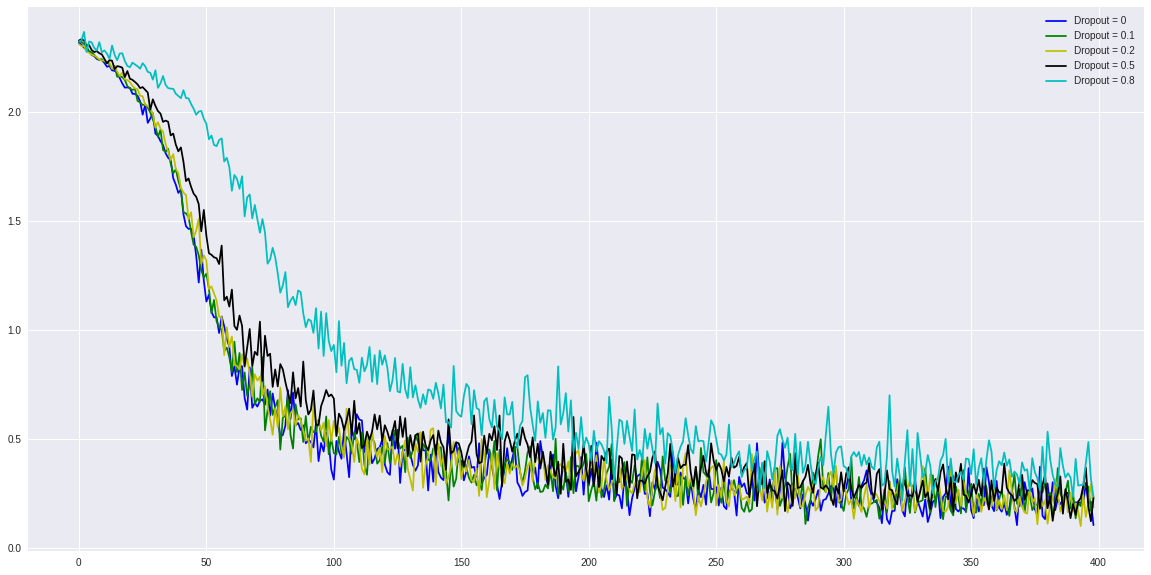

In [0]:
plt.gcf().clear()
plt.figure(figsize=(20,10))
for i in range(len(vector_p)): 
  plt.plot(train_losses_m[i][0:399], colors[i], label = 'Dropout = ' + str(vector_p[i]))
  plt.legend(loc='upper right')
plt.show()

Finally, we will analise a model with little dropout after max poolings (0.15) and variable dropout in the first fully-connected layer

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
        self.dropout = nn.Dropout()
        self.dropout2d = nn.Dropout2d()

    def forward(self, x, p):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.dropout2d(x,0.15)
        x = F.relu(self.conv2(x))        
        x = F.max_pool2d(x, 2, 2)
        x = F.dropout2d(x,0.15)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = F.dropout(x,p)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

The dropout probability is: 0
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.296069
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.854900
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.467306
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.366534
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.210043
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.199395

Validation set: Average loss: 0.2134, Accuracy: 9377/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.228429
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.295885
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.134022
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.197851
Train Epoch: 2 [40960/60000 (68%)]	Loss: 0.156558
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.115046

Validation set: Average loss: 0.1312, Accuracy: 9606/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.098308
Train Epoch: 3 [10240/60000 (17%)]	Loss: 0.102217
Train Epoch: 3 [20480/60000 (34%)]	Loss: 0.059208
Train Epoch: 3 [30720/60000 (51%)]	Loss: 0.084359
Train Epoch: 3 [40960/60000 (68%)]	Loss: 0.080610
T

<Figure size 576x396 with 0 Axes>

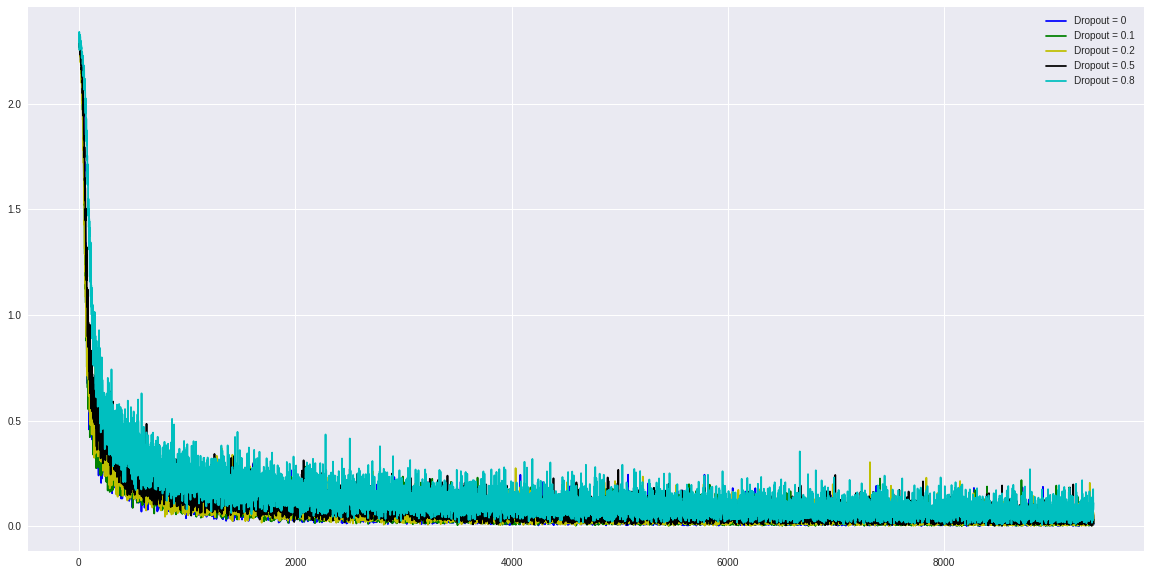

<Figure size 576x396 with 0 Axes>

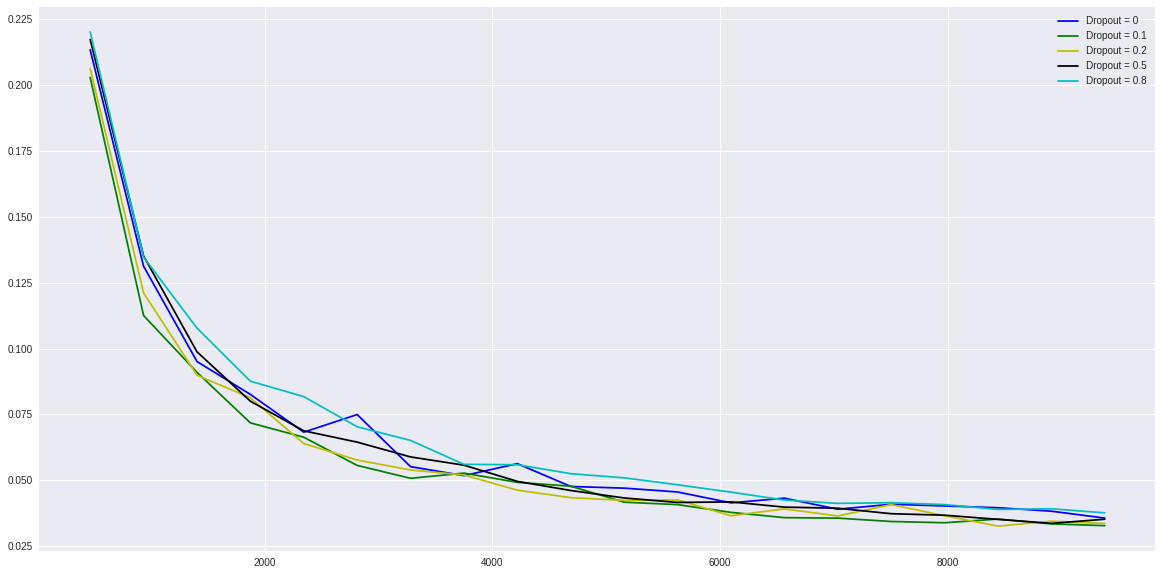

<Figure size 576x396 with 0 Axes>

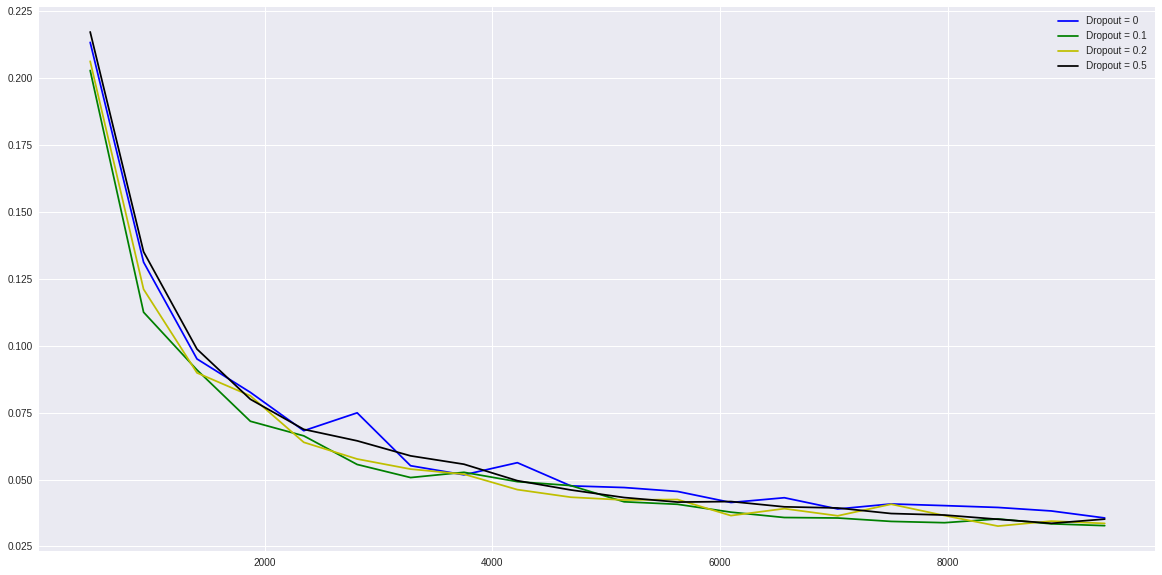

<Figure size 576x396 with 0 Axes>

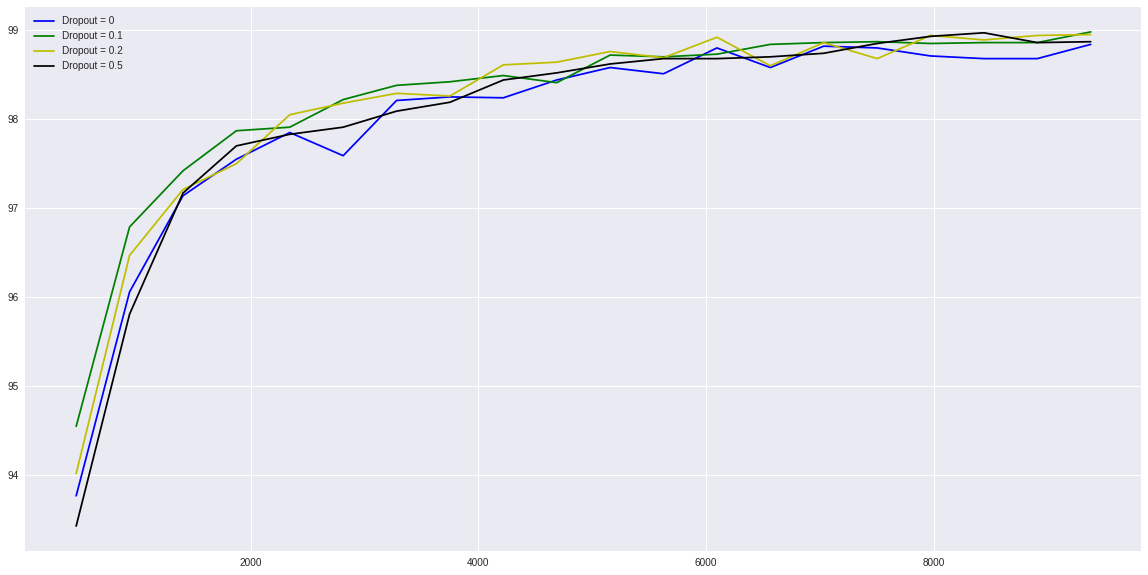

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vector_p=[0,0.1,0.2,0.5,0.8]
colors=['b-', 'g-', 'y-', 'k-', 'c-']
train_losses_m = []
valid_losses_m = []
valid_x_m = []
accuracy_m = []
plt.gcf().clear()
plt.figure(figsize=(20,10))
for p in vector_p:
  model = Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
  print("The dropout probability is: "+str(p))
  train_losses = []
  valid_losses = []
  valid_x=[]
  accuracies = []
  num_epochs = 20
  for epoch in range(1, num_epochs + 1):
      epoch_losses = train(80, model, device, train_loader, optimizer, epoch, p)
      train_losses.extend(epoch_losses)
      valid_loss, accuracy = validate(model, device, valid_loader)
      valid_losses.append([valid_loss])
      accuracies.append([accuracy])
      valid_x.append(len(train_losses) - 1)
  valid_x_m.append(valid_x)
  train_losses_m.append(train_losses)
  valid_losses_m.append(valid_losses)
  accuracy_m.append(accuracies)

  plt.plot(train_losses, colors[vector_p.index(p)], label = 'Dropout = ' + str(p) )
  plt.legend(loc='upper right')
 
plt.show()
plt.gcf().clear()
plt.figure(figsize=(20,10))
for i in range(len(vector_p)): 
  plt.plot(valid_x_m[i], valid_losses_m[i], colors[i], label = 'Dropout = ' + str(vector_p[i]))
  plt.legend(loc='upper right')
plt.show()

plt.gcf().clear()
plt.figure(figsize=(20,10))
for i in range(len(vector_p)-1): 
  plt.plot(valid_x_m[i], valid_losses_m[i], colors[i], label = 'Dropout = ' + str(vector_p[i]))
  plt.legend(loc='upper right')
plt.show()

plt.gcf().clear()
plt.figure(figsize=(20,10))
for i in range(len(vector_p)-1): 
  plt.plot(valid_x_m[i], accuracy_m[i], colors[i], label = 'Dropout = ' + str(vector_p[i]))
  plt.legend(loc='upper left')
plt.show()




<Figure size 576x396 with 0 Axes>

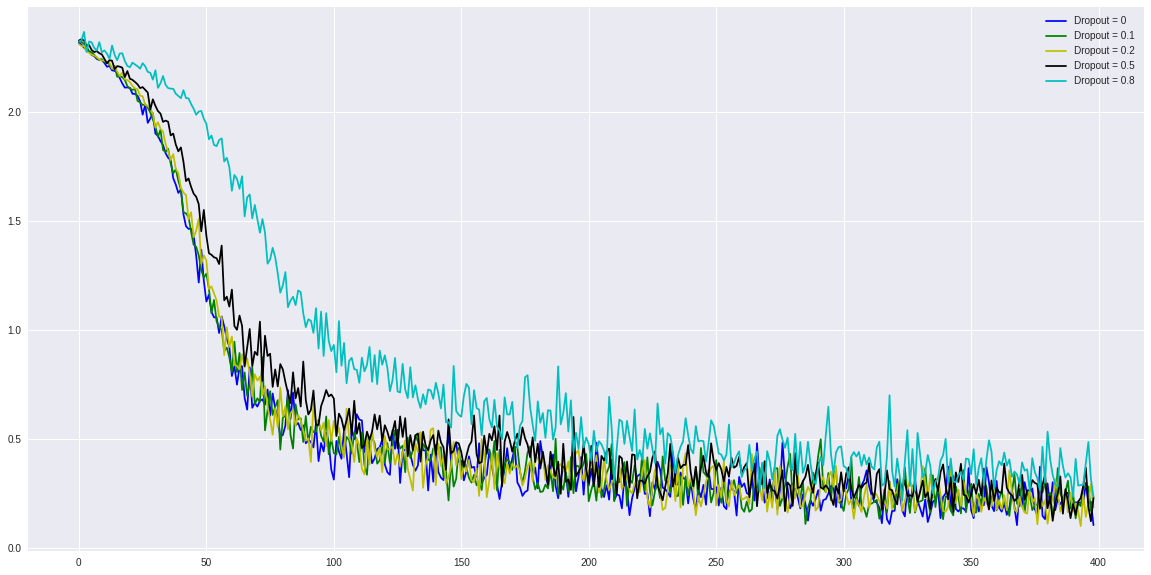

In [0]:
plt.gcf().clear()
plt.figure(figsize=(20,10))
for i in range(len(vector_p)): 
  plt.plot(train_losses_m[i][0:399], colors[i], label = 'Dropout = ' + str(vector_p[i]))
  plt.legend(loc='upper right')
plt.show()